In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import pandas as pd
import os
from sklearn.preprocessing import MinMaxScaler
%matplotlib inline

## Parsing data from MongoDB

In [2]:
from pymongo import MongoClient
from datetime import datetime
client = MongoClient('52.79.241.214', 27017)
print("DB connection complete!!")

DB connection complete!!


In [3]:
DB_Coin = client["Coin-USD"]
Collection = DB_Coin['BTC']
import time
DB_schema = []
i = 0

for collect in Collection.find():
    #if i==2902:
    if i==905:
        continue
    temp_record = {}

    temp_record['open'] = collect['Open']
    temp_record['close'] = collect['Price']
    temp_record['high'] = collect['High']
    temp_record['low'] = collect['Low']
    temp_record['volume'] = collect['Volume']    
    temp_record['Date'] = collect['Date']
    DB_schema.append(temp_record)
    del temp_record
    i = i+1

## Data preprocessing

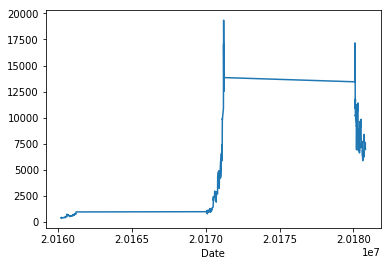

In [4]:
DF = pd.DataFrame(DB_schema)
DF.index = DF['Date']
DF['close'].plot()

In [5]:
DF.values.shape

(905, 6)

In [6]:
target_names = ['close']
shift_hours = 5
DF_targets = DF[target_names].shift(-shift_hours)

In [7]:
DF = DF[['close', 'high', 'low', 'open', 'volume']]
DF.head()

,close,high,low,open,volume
Date,,,,,
20180807,6952.3,6991.6,6914.8,6943.6,157830.0
20180806,6943.6,7143.6,6852.5,7027.8,168870.0
20180805,7027.1,7087.6,6887.9,7014.0,177640.0
20180804,7014.3,7484.2,6949.7,7418.9,222570.0
20180803,7419.0,7535.6,7293.5,7535.6,226460.0


In [8]:
DF_targets.head()

,close
Date,
20180807,7535.6
20180806,7606.4
20180805,7729.4
20180804,8177.1
20180803,8215.6


In [9]:
x_data = DF.values[0:-shift_hours]
print(type(x_data))
print("Shape: ", x_data.shape)

<class 'numpy.ndarray'>
Shape:  (900, 5)


In [10]:
y_data = DF_targets.values[:-shift_hours]
print(type(y_data))
print("Shape: ", y_data.shape)

<class 'numpy.ndarray'>
Shape:  (900, 1)


In [11]:
num_data = len(x_data)
train_split = 0.6
num_train = int(train_split * num_data)
num_test = num_data - num_train

In [12]:
print(num_train)
print(num_test)

540
360


In [13]:
x_train = x_data[0:num_train]
x_test = x_data[num_train:]
y_train = y_data[0:num_train]
y_test = y_data[num_train:]
num_x_signals = x_data.shape[1]
num_y_signals = y_data.shape[1]

In [14]:
x_scaler = MinMaxScaler()
x_train_scaled = x_scaler.fit_transform(x_train)  # 데이터의 크기를 0에서 1사이로 조정
print("Min:", np.min(x_train_scaled))
print("Max:", np.max(x_train_scaled))

Min: 0.0
Max: 1.0


In [15]:
x_test_scaled = x_scaler.transform(x_test)
y_scaler = MinMaxScaler()
y_train_scaled = y_scaler.fit_transform(y_train)
y_test_scaled = y_scaler.transform(y_test)

## Data Generation

In [16]:
def batch_generator(batch_size, sequence_length):
    """
    Generator function for creating random batches of training-data.
    """
    # Infinite loop.
    while True:
        # Allocate a new array for the batch of input-signals.
        x_shape = (batch_size, sequence_length, num_x_signals)
        x_batch = np.zeros(shape=x_shape, dtype=np.float16)
        # Allocate a new array for the batch of output-signals.
        y_shape = (batch_size, sequence_length, num_y_signals)
        y_batch = np.zeros(shape=y_shape, dtype=np.float16)
        # Fill the batch with random sequences of data.
        for i in range(batch_size):
            # Get a random start-index.
            # This points somewhere into the training-data.
            idx = np.random.randint(num_train - sequence_length)
            # Copy the sequences of data starting at this index.
            x_batch[i] = x_train_scaled[idx:idx+sequence_length]
            y_batch[i] = y_train_scaled[idx:idx+sequence_length]
        yield (x_batch, y_batch)

In [18]:
#batch_size = 256
batch_size = 3
sequence_length = 240
generator = batch_generator(batch_size=batch_size, sequence_length=sequence_length)

In [19]:
x_batch, y_batch = next(generator)

In [20]:
# Provides randomized 256 batches. Each sequence has 1344 time-series observations. Each observation has 5 inputs and 1 outputs
print(x_batch.shape)
print(y_batch.shape)

(3, 240, 5)
(3, 240, 1)


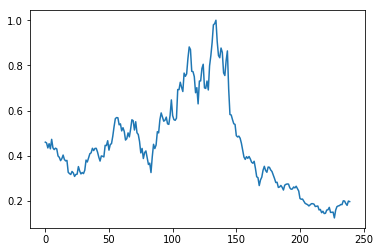

In [21]:
batch = 0 # First sequence in the batch.
signal = 0 # First signal from the 20 input-signals.
seq = x_batch[batch, :, signal]
plt.plot(seq)

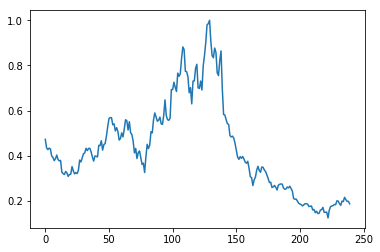

In [22]:
seq = y_batch[batch, :, signal]
plt.plot(seq)

#### Validation set

In [23]:
validation_data = (np.expand_dims(x_test_scaled, axis=0), np.expand_dims(y_test_scaled, axis=0))

# Auto-Encoder

In [ ]:
from keras.layers import Input, Dense
from keras.models import Model
from keras import backend as K


############################################################################# ???
def Auto_encoder_cost(X_input, H_Layer, X_reconstructed, W_ih, W_hr):
    ############# Hyper-parameter #############
    param_sparsity = 0.01
    Lambda = 0.0001 # param_weight_decay
    Beta = 3 # param_sparse_panelty
    ###########################################
    
    average_act_hidden = tf.reduce_mean(H_Layer,axis=0)   #Average hidden layer over all data points in X, Page 14 in https://web.stanford.edu/class/cs294a/sparseAutoencoder_2011new.pdf
    diff = X_input - X_reconstructed
    KL = Kullback_Leibler_divergence(param_sparsity, average_act_hidden)
    cost= 0.5*tf.reduce_mean(tf.reduce_sum(tf.pow(diff,2),axis=1)) + 0.5*Lambda*(tf.nn.l2_loss(W_ih) + tf.nn.l2_loss(W_hr)) + Beta*tf.reduce_sum(KL)
    return cost

def Kullback_Leibler_divergence(rho, rho_hat):
    return rho * tf.log(rho) - rho * tf.log(rho_hat) + (1 - rho) * tf.log(1 - rho) - (1 - rho) * tf.log(1 - rho_hat) 


def Single_Layer_Autoencoder(input_dim, encoding_dim=4):
    
    # this is our input placeholder
    input_encode = Input(shape=(input_dim,))
    # "encoded" is the encoded representation of the input
    encoded = Dense(encoding_dim, activation='sigmoid')(input_encode)
    decoded = Dense(input_dim, activation='sigmoid')(encoded)
    # this model maps an input to its reconstruction
    autoencoder = Model(input_encode, decoded)
    autoencoder_cost = Auto_encoder_cost(encoded)
    autoencoder.compile(optimizer='sgd', loss=autoencoder_cost)
    return autoencoder


def Get_layer_values(model, layer_idx):
    get_values = K.function([model.layers[0].input], [model.layers[layer_idx].output])
    return get_values([x])[0]
    
autoencoder1 = Single_Layer_Autoencoder(5, 4)
autoencoder1.fit(x_batch, x_batch, nb_epoch=20, batch_size=16)
autoencoder2 = Single_Layer_Autoencoder(4, 4)
autoencoder1_hidden = Get_layer_values(autoencoder1, 1)
autoencoder2.fit(autoencoder1_hidden, autoencoder1_hidden, nb_epoch=20, batch_size=16)
autoencoder3 = Single_Layer_Autoencoder(4, 4)
autoencoder2_hidden = Get_layer_values(autoencoder2, 1)
autoencoder3.fit(autoencoder2_hidden, autoencoder2_hidden, nb_epoch=20, batch_size=16)
autoencoder4 = Single_Layer_Autoencoder(4, 4)
autoencoder3_hidden = Get_layer_values(autoencoder3, 1)
autoencoder4.fit(autoencoder3_hidden, autoencoder3_hidden, nb_epoch=20, batch_size=16)
autoencoder4_output = Get_layer_values(autoencoder4, -1)

num_x_signals = autoencoder4_output.shape[1]




## Build a LSTM model

In [24]:
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Input, Dense, LSTM, Embedding
from tensorflow.python.keras.optimizers import Adagrad
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau

In [25]:
LSTM_model = Sequential()
#LSTM_model.add(LSTM(units=512, return_sequences=True, input_shape=(None, num_x_signals,)))
LSTM_model.add(LSTM(units=220, return_sequences=True, input_shape=(None, num_x_signals,)))
LSTM_model.add(Dense(num_y_signals, activation='sigmoid'))
if False:
    from tensorflow.python.keras.initializers import RandomUniform
    # Maybe use lower init-ranges.
    init = RandomUniform(minval=-0.05, maxval=0.05)
    LSTM_model.add(Dense(num_y_signals, activation='linear', kernel_initializer=init))

### Loss Function

In [26]:
warmup_steps = 50
def loss_mse_warmup(y_true, y_pred):
    """
    Calculate the Mean Squared Error between y_true and y_pred,
    but ignore the beginning "warmup" part of the sequences.
    y_true is the desired output.
    y_pred is the model's output.
    """
    # The shape of both input tensors are:
    # [batch_size, sequence_length, num_y_signals].
    # Ignore the "warmup" parts of the sequences
    # by taking slices of the tensors.
    y_true_slice = y_true[:, warmup_steps:, :]
    y_pred_slice = y_pred[:, warmup_steps:, :]
    
    # These sliced tensors both have this shape:
    # [batch_size, sequence_length - warmup_steps, num_y_signals]
    # Calculate the MSE loss for each value in these tensors.
    # This outputs a 3-rank tensor of the same shape.
    #losses = [tf.nn.sparse_softmax_cross_entropy_with_logits(labels=labels, logits=logits) for logits, labels in zip(logits_series,labelsSeries)]
    loss = tf.losses.mean_squared_error(labels=y_true_slice, predictions=y_pred_slice)
    
    # Keras may reduce this across the first axis (the batch)
    # but the semantics are unclear, so to be sure we use
    # the loss across the entire tensor, we reduce it to a
    # single scalar with the mean function.
    loss_mean = tf.reduce_mean(loss)
    return loss_mean

from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

# Mean Absolute percentage error
def mean_absolute_percentage_error(y_true, y_pred):
    #y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Theil_U
def Theil_U(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return(np.mean((np.square(y_true - y_pred)))/(np.sqrt(np.mean(np.square(y_true)))+np.sqrt(np.mean(np.square(y_pred)))))

## Model Compile

In [27]:
optimizer = Adagrad(lr=1e-4)
LSTM_model.compile(loss=loss_mse_warmup, optimizer=optimizer)

In [28]:
LSTM_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, None, 220)         198880    
_________________________________________________________________
dense (Dense)                (None, None, 1)           221       
Total params: 199,101
Trainable params: 199,101
Non-trainable params: 0
_________________________________________________________________


In [ ]:
from tensorflow.python.keras.utils import plot_model
#from tensorflow.python.keras.utils.vis_utils import plot_model
plot_model(LSTM_model, to_file='LSTM_demo.png', show_shapes=True)

#from IPython.display import SVG
#from tensorflow.python.keras.utils.vis_utils import model_to_dot

#SVG(model_to_dot(LSTM_model).create(prog='dot', format='svg'))

### Callback functions for TensorBoard

In [29]:
path_checkpoint = '23_checkpoint.keras'
## Recording checkpoints
callback_checkpoint = ModelCheckpoint(filepath=path_checkpoint, monitor='val_loss', verbose=1, save_weights_only=True, save_best_only=True)
## If performance in Validation set gets worse, then stop training
callback_early_stopping = EarlyStopping(monitor='val_loss',patience=5, verbose=1)
## 
callback_tensorboard = TensorBoard(log_dir='./logs/SAE_test10',histogram_freq=0,write_graph=False)
callback_reduce_lr = ReduceLROnPlateau(monitor='val_loss',factor=0.1,min_lr=1e-4,patience=0,verbose=1)
callbacks = [callback_early_stopping, callback_checkpoint, callback_tensorboard, callback_reduce_lr]

## Train the model

In [30]:
%%time
LSTM_model.fit_generator(generator=generator, epochs=50, steps_per_epoch=100, validation_data=validation_data, callbacks=callbacks)

Epoch 1/50
 99/100 [============================>.] - ETA: 0s - loss: 0.0884
Epoch 00001: val_loss improved from inf to 0.26170, saving model to 23_checkpoint.keras
100/100 [==============================] - 28s 275ms/step - loss: 0.0887 - val_loss: 0.2617
Epoch 2/50
 99/100 [============================>.] - ETA: 0s - loss: 0.0880
Epoch 00002: val_loss improved from 0.26170 to 0.25556, saving model to 23_checkpoint.keras
100/100 [==============================] - 26s 262ms/step - loss: 0.0879 - val_loss: 0.2556
Epoch 3/50
 99/100 [============================>.] - ETA: 0s - loss: 0.0800
Epoch 00003: val_loss improved from 0.25556 to 0.24847, saving model to 23_checkpoint.keras
100/100 [==============================] - 26s 261ms/step - loss: 0.0797 - val_loss: 0.2485
Epoch 4/50
 99/100 [============================>.] - ETA: 0s - loss: 0.0837
Epoch 00004: val_loss improved from 0.24847 to 0.23439, saving model to 23_checkpoint.keras
100/100 [==============================] - 26s 265ms

Epoch 33/50
 99/100 [============================>.] - ETA: 0s - loss: 0.0100
Epoch 00033: val_loss improved from 0.00567 to 0.00567, saving model to 23_checkpoint.keras
100/100 [==============================] - 27s 265ms/step - loss: 0.0100 - val_loss: 0.0057
Epoch 34/50
 99/100 [============================>.] - ETA: 0s - loss: 0.0105
Epoch 00034: val_loss improved from 0.00567 to 0.00556, saving model to 23_checkpoint.keras
100/100 [==============================] - 26s 263ms/step - loss: 0.0105 - val_loss: 0.0056
Epoch 35/50
 99/100 [============================>.] - ETA: 0s - loss: 0.0108
Epoch 00035: val_loss improved from 0.00556 to 0.00534, saving model to 23_checkpoint.keras
100/100 [==============================] - 26s 263ms/step - loss: 0.0109 - val_loss: 0.0053
Epoch 36/50
 99/100 [============================>.] - ETA: 0s - loss: 0.0102
Epoch 00036: val_loss improved from 0.00534 to 0.00512, saving model to 23_checkpoint.keras
100/100 [==============================] - 2

### Read checkpoints when early-stopping occurs

In [31]:
try:
    LSTM_model.load_weights(path_checkpoint)
except Exception as error:
    print("Error trying to load checkpoint.")
    print(error)

## Evaluation the model to the test set

In [32]:
result = LSTM_model.evaluate(x=np.expand_dims(x_test_scaled, axis=0),
y=np.expand_dims(y_test_scaled, axis=0))

1/1 [==============================] - 0s 110ms/step


In [33]:
print("loss (test-set):", result)

loss (test-set): 0.0031846677884459496


In [ ]:
# 만약 여러가지 측정치를 사용한다면 다음의 방법으로 측정할 수 있습니다.
if False:
    for res, metric in zip(result, LSTM_model.metrics_names):
        print("{0}: {1:.3e}".format(metric, res))

## Visualization of prediction and real values

In [34]:
def plot_comparison(start_idx, length=100, train=True):
    """
    Plot the predicted and true output-signals.
    :param start_idx: Start-index for the time-series.
    :param length: Sequence-length to process and plot.
    :param train: Boolean whether to use training- or test-set.
    """
    if train:
        # Use training-data.
        x = x_train_scaled
        y_true = y_train
    else:
        # Use test-data.
        x = x_test_scaled
        y_true = y_test
    
    # End-index for the sequences.
    end_idx = start_idx + length
    # Select the sequences from the given start-index and
    # of the given length.
    x = x[start_idx:end_idx]
    y_true = y_true[start_idx:end_idx]
    # Input-signals for the model.
    x = np.expand_dims(x, axis=0)
    # Use the model to predict the output-signals.
    y_pred = LSTM_model.predict(x)
    # The output of the model is between 0 and 1.
    # Do an inverse map to get it back to the scale
    # of the original data-set.
    y_pred_rescaled = y_scaler.inverse_transform(y_pred[0])
    # For each output-signal.
    for signal in range(len(target_names)):
        # Get the output-signal predicted by the model.
        signal_pred = y_pred_rescaled[:, signal]
        # Get the true output-signal from the data-set.
        signal_true = y_true[:, signal]
        # Make the plotting-canvas bigger.
        plt.figure(figsize=(15,5))
        # Plot and compare the two signals.
        plt.plot(signal_true, label='true')
        plt.plot(signal_pred, label='pred')
        # Plot grey box for warmup-period.
        p = plt.axvspan(0, warmup_steps, facecolor='black', alpha=0.15)
        # Plot labels etc.
        plt.ylabel(target_names[signal])
        plt.legend()
        plt.show()

In [ ]:
plot_comparison(start_idx=10, length=100, train=True)

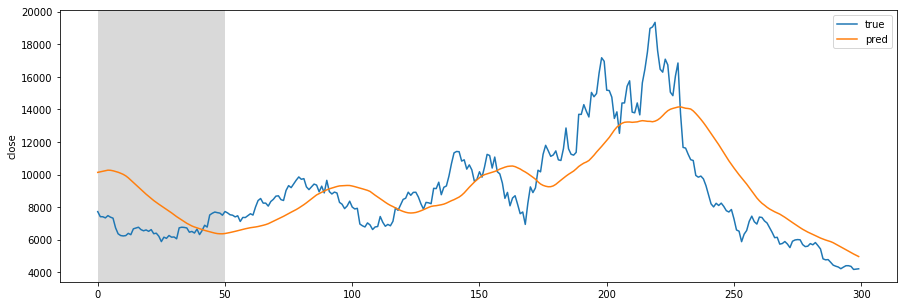

In [35]:
plot_comparison(start_idx=10, length=300, train=True)

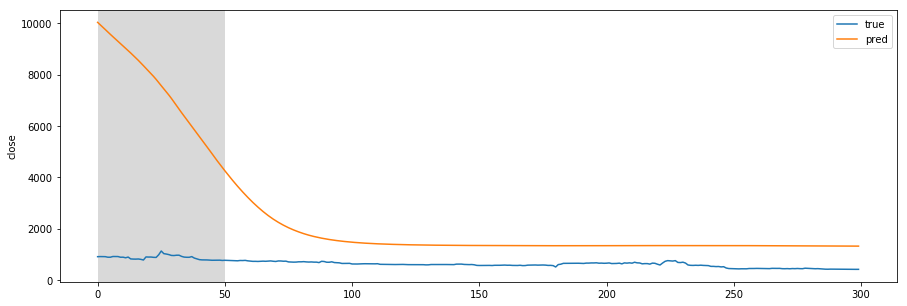

In [37]:
plot_comparison(start_idx=10, length=300, train=False)

plot_comparison(start_idx=10, length=250, train=False)